In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [26]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics})


In [5]:
agg1_stds.columns

Index(['circuit_name', 'mutation_num', 'sample_name',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_species-6_ratio_from_mutation_to_base'],
      dtype='object')

In [6]:
s
sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)


NameError: name 's' is not defined

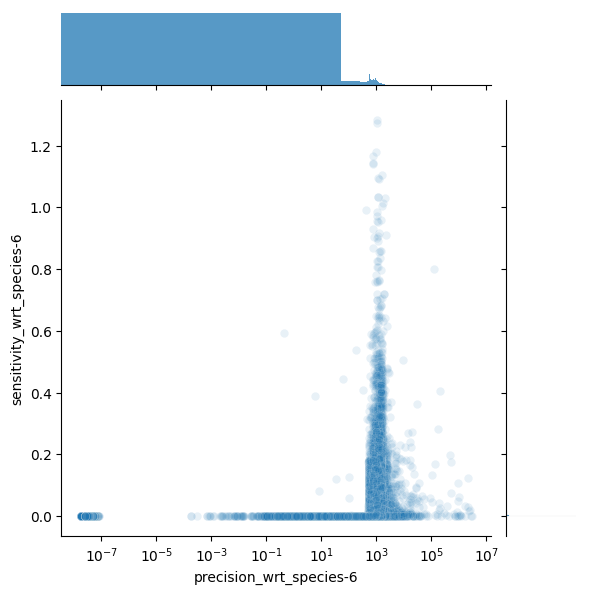

In [ ]:
sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)
plt.xscale('log')

Find joint min of precision and std differences between all circuits and max of precision STD difference

In [7]:
p = agg1_mean[(agg1_mean['sample_name'] != 'RNA_0') & (agg1_mean['precision_wrt_species-6'] != np.inf)]['precision_wrt_species-6'].to_numpy()
prec_diffs = np.log(p[:, None]) - np.log(p[None, :])

In [21]:
s = agg1_mean[agg1_mean['sample_name'] != 'RNA_0']['sensitivity_wrt_species-6'].to_numpy()
sens_diffs = np.log(s[:, None]) - np.log(s[None, :])


In [27]:
std_diffs = agg1_stds[agg1_stds['sample_name'] != 'RNA_0']['precision_wrt_species-6'].to_numpy()[:, None] - agg1_stds[agg1_stds['sample_name'] != 'RNA_0']['precision_wrt_species-6'].to_numpy()[None, :]

In [29]:
joint = std_diffs + prec_diffs + sens_diffs

ValueError: operands could not be broadcast together with shapes (28000,28000) (27996,27996) 

<AxesSubplot: ylabel='Count'>

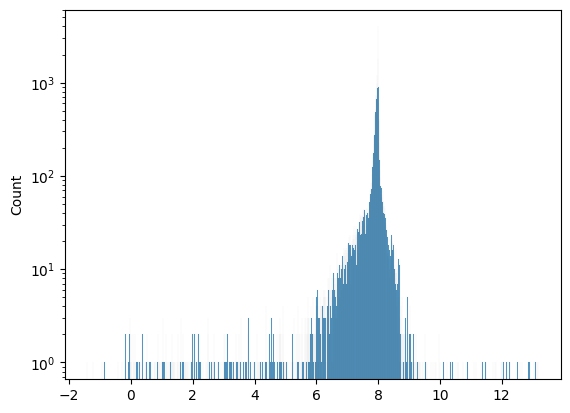

In [20]:
joint = sens_diffs